In [1]:
# On importe les librairies dont on aura besoin
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import array
import requests

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn import neighbors
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

## Compréhension du problème

L'objectif est d'améliorer le modèle de prédiction de loyer (fonction de la surface), à l'aide d'une feature (variable) supplémentaire (l'arrondissement).

## Méthodologie

1. Import des données
2. Nettoyage des données (suppression des données manquantes, justification)
3. Exploration de la nouvelle feature
4. Représentations des données
5. Séparation des training / testing set
    * Données commune pour les modèles à comparer
6. Modèle de regression linéaire baseline
7. Amélioration 1 : Modèles de regression linéaire par arrondissement
8. Amélioration 2 : Prendre en compte les outliers par arrondissement

### 1. Import des données

On récupère les données depuis un fichier csv dans un dataframe pandas.

In [14]:
house_data = pd.read_csv('house_data.csv')

print("Volume des données importées : {}".format(str(house_data.shape)))

Volume des données importées : (827, 3)


### 2. Nettoyage des données

L'objectif est d'avoir des données valides en entrée des modèles à tester.

In [15]:
# On identifie les lignes du dataset avec des données manquantes (isnan).
house_data_error = house_data[np.isnan(house_data).any(axis=1)]

# On identifie les lignes du dataset avec des outliers.
# house_data_outlier_X = house_data[house_data["surface"] > 300]
# house_data_outlier_y = house_data[house_data["price"] > 13000]

print("Données incomplètes :\n")
print("{}\n".format(str(house_data_error)))

# print("Outliers X :\n")
# print("{}\n".format(str(house_data_outlier_X)))

# print("Outliers y :\n")
# print("{}\n".format(str(house_data_outlier_y)))

# Suppression des enregistrements des données incomplètes
house_data = house_data[~np.isnan(house_data).any(axis=1)]

# Suppression des outliers
# house_data = house_data[house_data["surface"] < 300]
# house_data = house_data[house_data["price"] < 13000]

print("Volume des données nettoyées : {}".format(str(house_data.shape)))

Données incomplètes :

     price  surface  arrondissement
149   3000      NaN             NaN
339    980      NaN             NaN
509   1590      NaN             NaN
674   1580      NaN             NaN
742    450      NaN             NaN

Volume des données nettoyées : (822, 3)


#### Commentaire
 * Certains enregistrements sont incomplets sur la surface et l'arrondissement.
     * On ne peut pas les compléter (par approximation locale par exemple).
     * On choisi donc de les supprimer.

### 3. Exploration de la nouvelle feature

L'objectif est d'explorer cette nouvelle donnée pour comprendre comment l'exploiter.

In [16]:
# Recherche de la liste des valeurs uniques
liste_arrondissements_ini = np.unique(house_data.arrondissement)

print("Nombre d'arrondissements  : {}\n".format(str(len(liste_arrondissements_ini))))
print("Liste des arrondissements          : {}".format(str(liste_arrondissements_ini)))

# Conversion des arrondissements au format géographique
# source : http://adresse.data.gouv.fr/
# house_data.arrondissement = house_data.arrondissement.replace(\
#                                                          [1, 2, 3 , 4, 10],\
#                                                          [(48.8638,2.3357),
#                                                           (48.8667,2.3512),
#                                                           (48.8637,2.3586),
#                                                           (48.8517,2.3645),
#                                                           (48.8759,2.3564)])

liste_arrondissements = np.unique(house_data.arrondissement)
print("Liste des arrondissements renommés : {}".format(str(liste_arrondissements)))

#loc_arrondissement = [[1, 48.8638, 2.3357],
#                      [2, 48.8667, 2.3512],
#                      [3, 48.8637, 2.3586],
#                      [4, 48.8517, 2.3645],
#                      [10, 48.8759, 2.3564]]

#latitude = house_data.arrondissement.replace([1, 2, 3 , 4, 10],
#                                       [48.8638, 48.8667, 48.8637, 48.8517, 48.8759])
#longitude = house_data.arrondissement.replace([1, 2, 3 , 4, 10],
#                                       [2.3357, 2.3512, 2.3586, 2.3645, 2.3564])

#house_data[house_data["arrondissement"] == 1]['latitude'] = 48.8638

print(house_data)

#house_data.join(latitude, lsuffix='_house_data', rsuffix='_latitude')
#house_data.join(longitude, lsuffix='_house_data', rsuffix='_longitude')
#print(house_data)

Nombre d'arrondissements  : 5

Liste des arrondissements          : [  1.   2.   3.   4.  10.]
Liste des arrondissements renommés : [  1.   2.   3.   4.  10.]
     price  surface  arrondissement
0     1820    46.10             1.0
1     1750    41.00             1.0
2     1900    55.00             1.0
3     1950    46.00             1.0
4     1950    49.00             1.0
5     1960    67.00             1.0
6     2000    35.00             1.0
7     1900    90.60             1.0
8     2050    60.00             1.0
9     2100    47.00             1.0
10    2100    55.00             1.0
11    2145    68.95             1.0
12    2200    40.00             1.0
13    2216    68.95             1.0
14    2249    35.00             1.0
15    2300    70.90             1.0
16    2367    76.00             1.0
17    2390    71.00             1.0
18    2342    80.00             1.0
19    2315    71.00             1.0
20    2500    84.35             1.0
21    2470    55.00             1.0
22    2650   

/Users/Nicolas/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### Commentaires

 * Le nombre de valeurs de la nouvelle feature est limité (devant la diversité des surfaces et des prix)
     * 5 arrondissements sont présent dans le jeu de données
 * Le numéro d'arrondissement est au format numérique
     * Ce format n'a pas de sens puisqu'il s'agit d'une dénomisation, non d'une quantité
     * Une régression linéaire avec cette donnée au format numérique n'aurais pas de sens
     * On préfère le renommer dans un nouveau format (str)

### 4. Représentation des données

L'idée est de représenter les données avec cette nouvelle feature.

L'objectif est de comprendre comment elle pourrait améliorer la prédiction du modèle linéaire initial.

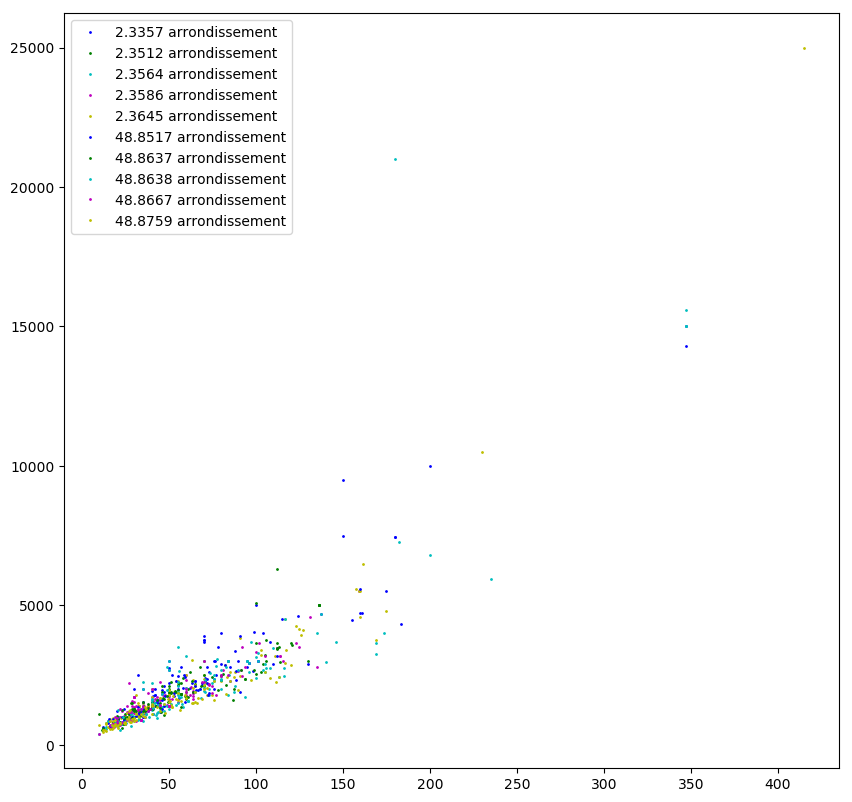

In [227]:
# Initialisation du tableau des arrondissements
house_data_arrondissements = []

# Création de la liste des arrondissements
for arrondissement_value in liste_arrondissements:
    house_data_arrondissements.append(house_data[house_data.arrondissement == arrondissement_value])

# Initialisation des couleurs pour les graphes
colors_ = ['bo','go','co','mo','yo']

# Initialisation du graphe de représentation des données
plt.figure(figsize=(10, 10), dpi=100)

# Création du graphe de représentation des données par arrondissement
i = 0
for d, c in zip(house_data_arrondissements, itertools.cycle(colors_)):
    plt.plot(d["surface"], d["price"], c, markersize=1, \
             label=str(liste_arrondissements[i]) + " arrondissement")
    i += 1
    
plt.legend()
plt.show()

#### Commentaires

 * Les données semblent correspondre à un modèle linéaire
 * On constate des outliers sur le prix (>13000) et la surface (>300) pour les 1er et 4éme arrondissements.
    * Hypothèse : Erreur sur les données ?
    * Hypothèse : Biens d'exception ?
 * Il semble qu'une droite de régression aurait une pente différente selon l'arrondissement
    avec à priori une erreur moindre que pour un modèle global
    * Hypothèse : Marché de la location différent selon les arrondissements ?
    
### 5. Séparation des training / testing set

On utilise 80% des données pour le training set et les 20% restant pour le testing set (par tirage au sort uniforme).

In [190]:
data = np.array([house_data["arrondissement"], house_data["surface"]]).T
target = np.array([house_data["price"]]).T

X_train, X_test, y_train, y_test = train_test_split(data, target, train_size=0.8)

print("X_train : {}".format(str(X_train.shape)))
print("X_test  : {}".format(str(X_test.shape)))

X_train : (652, 2)
X_test  : (163, 2)


#### Commentaire

 * On dispose de 657 enregistrements pour le training set et 165 pour le testing set.

### 6. Modèle de regression linéaire baseline

Définition d'un modèle de régression linéaire sans l'arrondissement sur la base des training / testing set défini plus haut.

erreur modèle : 18.39 %


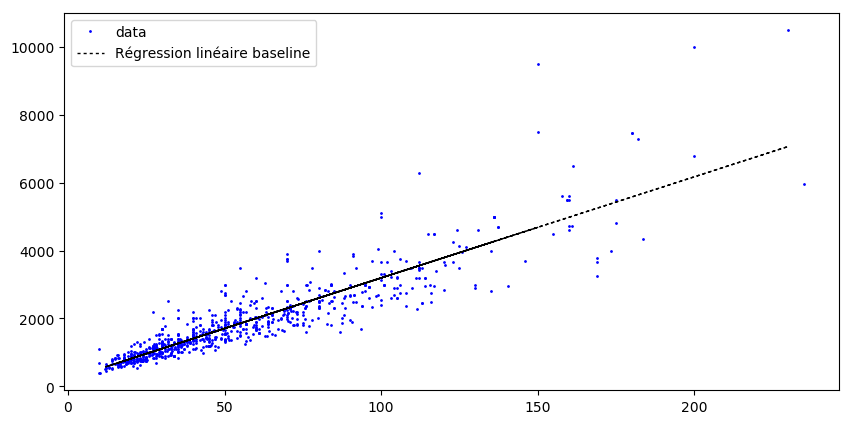

In [191]:
X_train_bl = X_train.T[1].reshape(-1,1)
X_test_bl = X_test.T[1].reshape(-1,1)

reg_bl = linear_model.LinearRegression()
reg_bl.fit(X_train_bl, y_train)

print("erreur modèle : {} %".format(str(round((1 - reg_bl.score(X_test_bl, y_test)) * 100, 2))))

line_y = reg_bl.predict(X_test_bl)

plt.figure(figsize=(10, 5), dpi=100)
plt.plot(house_data["surface"], house_data["price"], 'bo', markersize=1, label="data")
plt.plot(X_test_bl, line_y, color='k', linestyle=':', linewidth=1,
         label='Régression linéaire baseline')
plt.legend()
plt.show()

#### Commentaires

 * On constate que l'erreur est parfois importante selon l'échantillon des données d'entrainement et de test
 * La prise en compte des outliers tant à fausser le modèle
 
### 7. Amélioration 1 : Modèles de regression linéaire par arrondissement

L'objectif est de créer des modèles de régression linéaire spécialisé par arrondissement sur la base des training / testing set du modèle précédent.

erreur modèle 10eme arrondissement : 5.51 %
erreur modèle 1er arrondissement : 18.38 %
erreur modèle 2eme arrondissement : 7.33 %
erreur modèle 3eme arrondissement : 19.71 %
erreur modèle 4eme arrondissement : 17.59 %


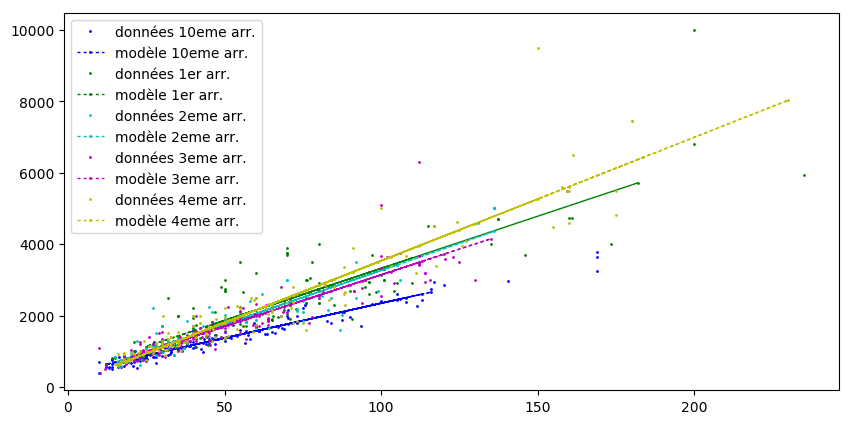

In [192]:
# Formattage des données pour les fonctions de sélection
_X_train = X_train.T[0]
_y_train = y_train.T[0]
_X_test = X_test.T[0]
_y_test = y_test.T[0]

# Initialisation de la liste des modèles
modeles = {}

# Initialisation du graphe de représentation des résultats
plt.figure(figsize=(10, 5), dpi=100)

# Création d'un modèle et d'un graphe pour chaque arrondissement
for a, c in zip(liste_arrondissements, itertools.cycle(colors_)):
    
    # Réduction des training / testing set à l'arrondissement courant
    _X_train_a = X_train[(_X_train == a)].T[1].reshape(-1,1)
    _y_train_a = y_train[(_X_train == a)].reshape(-1,1)
    _X_test_a = X_test[(_X_test == a)].T[1].reshape(-1,1)
    _y_test_a = y_test[(_X_test == a)].reshape(-1,1)
    
    # Création et entrainement du modèle
    reg = linear_model.LinearRegression()
    reg.fit(_X_train_a, _y_train_a)
    modeles[a] = reg
    
    # Affichage de l'erreur du modèle courant
    print("erreur modèle {} arrondissement : {} %".format(a, str(round((1 - reg.score(_X_test_a, _y_test_a)) * 100,2))))
    
    # Création du graphe de résultat avec les données et le modèle courant
    _line_y_a = reg.predict(_X_test_a)
    plt.plot(_X_train_a, _y_train_a,
             c, markersize=1, label="données {} arr.".format(a))
    plt.plot(_X_test_a, _line_y_a,
             c, markersize=1, label="modèle {} arr.".format(a),
             linestyle=':', linewidth=1)

# Rendu du graphe final
plt.legend()
plt.show()

#### Commentaires

 * On améliore la prédiction localement pour certain arrondissements
 * Les arrondissement avec des outliers (1er et 4éme) ne sont pas significativement améliorés (voir dégradés)

### 8. Amélioration 2 : Prendre en compte les outliers par arrondissement

* Améliorer la robustesse des modèles en écartant les outliers
  * Les outlier sont des exceptions lié à des hypothèses particulière à priori non représentative sur phénomène
  * On propose de les écarter avec la méthode RANSAC

erreur modèle 10eme arrondissement : 5.72 %
erreur modèle 1er arrondissement : 28.66 %
erreur modèle 2eme arrondissement : 13.15 %
erreur modèle 3eme arrondissement : 14.49 %
erreur modèle 4eme arrondissement : 21.93 %


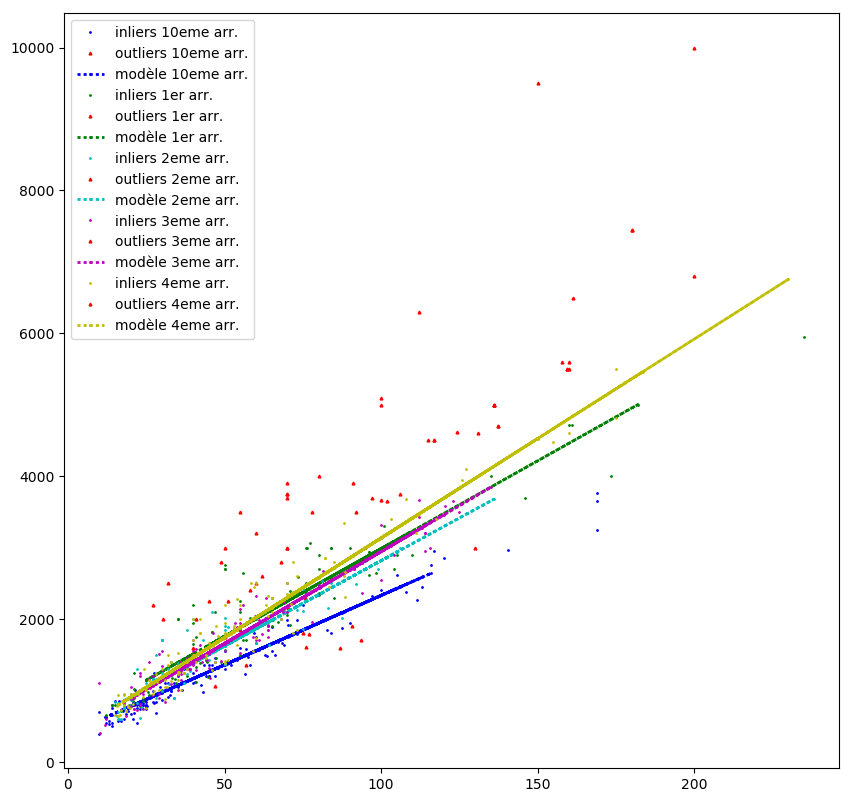

In [193]:
# Formattage des données pour les fonctions de sélection
_X_train = X_train.T[0]
_y_train = y_train.T[0]
_X_test = X_test.T[0]
_y_test = y_test.T[0]

# Initialisation de la liste des modèles
modeles_ransac = {}

# Initialisation du graphe de représentation des résultats
plt.figure(figsize=(10, 10), dpi=100)

# Création d'un modèle et d'un graphe pour chaque arrondissement
for a, c in zip(liste_arrondissements, itertools.cycle(colors_)):
    
    # Réduction des training / testing set à l'arrondissement courant
    _X_train_a = X_train[(_X_train == a)].T[1].reshape(-1,1)
    _y_train_a = y_train[(_X_train == a)].reshape(-1,1)
    _X_test_a = X_test[(_X_test == a)].T[1].reshape(-1,1)
    _y_test_a = y_test[(_X_test == a)].reshape(-1,1)
    
    # Création et entrainement du modèle
    model_ransac = linear_model.RANSACRegressor(linear_model.LinearRegression())
    model_ransac.fit(_X_train_a, _y_train_a)
    modeles_ransac[a] = model_ransac
    
    inlier_mask = model_ransac.inlier_mask_
    outlier_mask = np.logical_not(inlier_mask)
    
    # Affichage de l'erreur du modèle courant
    print("erreur modèle {} arrondissement : {} %".format(a, str(round((1 - model_ransac.score(_X_test_a, _y_test_a)) * 100,2))))
    
    # Création du graphe de résultat avec les données et le modèle courant
    _line_y_a = model_ransac.predict(_X_test_a)
    plt.plot(_X_train_a[inlier_mask], _y_train_a[inlier_mask],
             c, markersize=1, label="inliers {} arr.".format(a))
    plt.plot(_X_train_a[outlier_mask], _y_train_a[outlier_mask],
             'r^', markersize=2, label="outliers {} arr.".format(a))
    plt.plot(_X_test_a, _line_y_a,
             c, markersize=1, label="modèle {} arr.".format(a),
             linestyle=':', linewidth=2)

# Rendu du graphe final
plt.legend()
plt.show()

#### Commentaires
 * On visualise bien les données qui on été retirés du training set en rouge
 * Les erreurs sont un peu meilleures que la méthode précédente, toutefois on compte plus sur la robustesse du modèle devant des données plus hétérogènes (avec outliers)
 * L'autre méthode, plus simple, consiste à revoir les données initiales avec des hypothèses plus proche du phénomène que l'on souhaite étudier
     * Concrétement on pourrait supprimer les données avec un prix >13000 et une surface >300 afin de focaliser la modélisation sur des biens plus courant

erreur modèle : 24.04 %


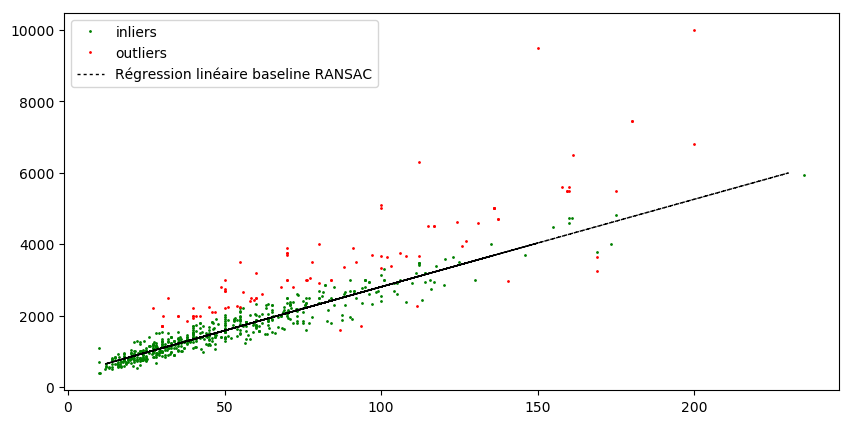

In [194]:
X_train_bl = X_train.T[1].reshape(-1,1)
X_test_bl = X_test.T[1].reshape(-1,1)

model_ransac_bl = linear_model.RANSACRegressor(linear_model.LinearRegression())
model_ransac_bl.fit(X_train_bl, y_train)
inlier_mask_bl = model_ransac_bl.inlier_mask_
outlier_mask_bl = np.logical_not(inlier_mask_bl)


print("erreur modèle : {} %".format(str(round((1 - model_ransac_bl.score(X_test_bl, y_test)) * 100, 2))))

line_y = model_ransac_bl.predict(X_test_bl)

plt.figure(figsize=(10, 5), dpi=100)
plt.plot(X_train_bl[inlier_mask_bl], y_train[inlier_mask_bl], 'go', markersize=1, label="inliers")
plt.plot(X_train_bl[outlier_mask_bl], y_train[outlier_mask_bl], 'ro', markersize=1, label="outliers")
plt.plot(X_test_bl, line_y, color='k', linestyle=':', linewidth=1,
         label='Régression linéaire baseline RANSAC')
plt.legend()
plt.show()

erreur modèle : 16.73 %


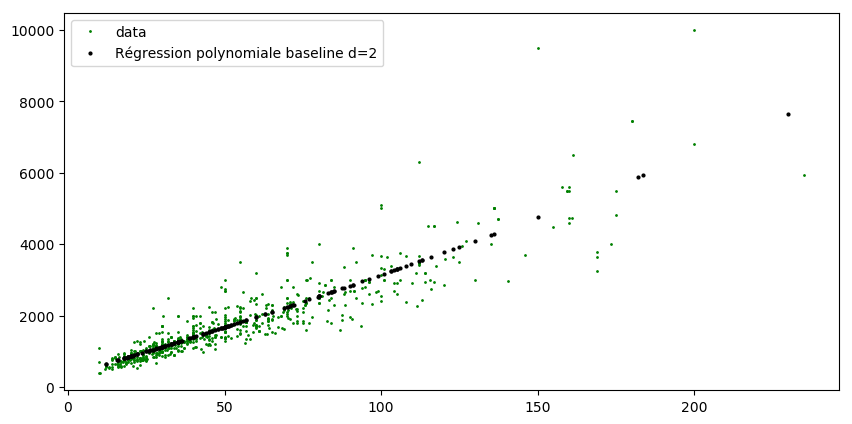

In [199]:
X_train_bl = X_train.T[1].reshape(-1,1)
X_test_bl = X_test.T[1].reshape(-1,1)

model_poly_bl = make_pipeline(PolynomialFeatures(2), linear_model.LinearRegression())
model_poly_bl.fit(X_train_bl, y_train)

print("erreur modèle : {} %".format(str(round((1 - model_poly_bl.score(X_test_bl, y_test)) * 100, 2))))

line_y = model_poly_bl.predict(X_test_bl)

plt.figure(figsize=(10, 5), dpi=100)
plt.plot(X_train_bl, y_train,'go', markersize=1, label="data")
plt.plot(X_test_bl, line_y,'ko', markersize=2, label='Régression polynomiale baseline d=2')
plt.legend()
plt.show()